In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from image_processing import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.18.0
Keras version:  3.6.0
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
from PIL import Image
def resize_dataset(dataset_path, classes):
    # Resize all images in the dataset to 128x128
    for folder in os.listdir(dataset_path):
        for class_name in classes:
            class_folder = os.path.join(dataset_path, folder, class_name)
            for image in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image)
                img = Image.open(image_path)
                img = img.resize((128, 128))
                img.save(image_path)

In [3]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'src_data')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset_grayscale_128')
models_dir = os.path.join(local_dir, 'models_grayscale_128')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

classes = ['rock', 'paper', 'scissors']
splits = ['train', 'val', 'test']

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir, split_proportions=[0.7, 0.15, 0.15])
    convert_images_to_grayscale(dataset_dir, splits, classes)
    resize_dataset(dataset_dir, classes)

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

Converting images to grayscale...
Converted 7228 images to grayscale, skipped 0 images.
./dataset_grayscale_128\train
    - rock: 1672 images
    - paper: 1686 images
    - scissors: 1700 images
./dataset_grayscale_128\val
    - rock: 358 images
    - paper: 361 images
    - scissors: 365 images
./dataset_grayscale_128\test
    - rock: 359 images
    - paper: 362 images
    - scissors: 365 images


In [4]:
check_for_duplicates_in_dataset('./dataset_grayscale')

No duplicates found in dataset
5728 files found in dataset


Found 5058 images belonging to 3 classes.
Found 1084 images belonging to 3 classes.
Found 1086 images belonging to 3 classes.


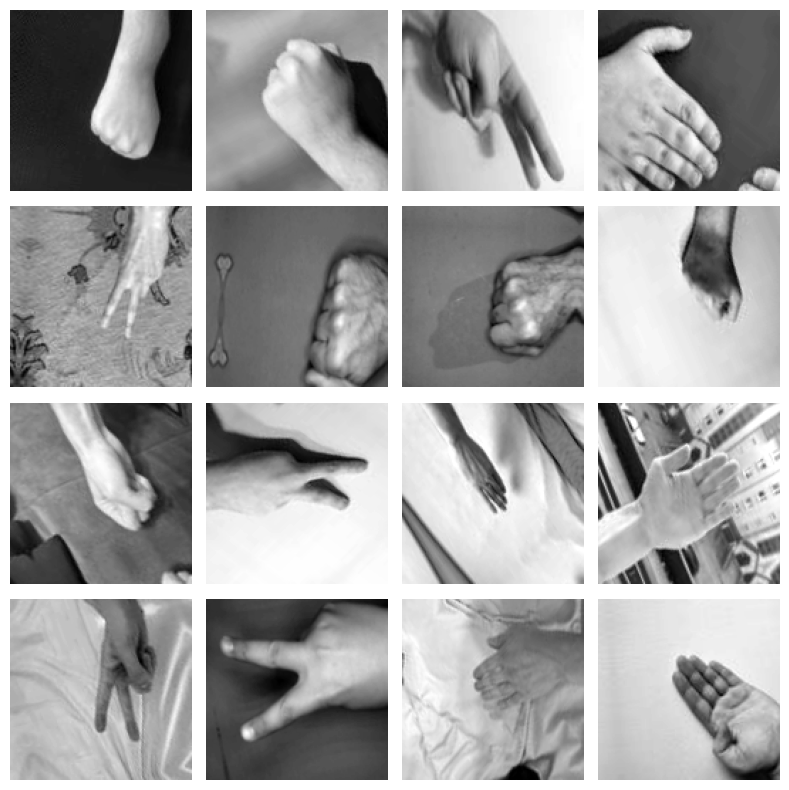

In [5]:
# Image target size
img_rows, img_cols = 128, 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    vertical_flip=True,
    brightness_range=[0.7, 1.4],
    preprocessing_function=lambda image: random_contrast_grayscale(image, 0.8, 1.2)
    )

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    zoom_range=[0.9, 1.1],
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

plot_grid_from_generator(train_generator, 4, 4, cmap='gray')

In [7]:
model_loaded = tf.keras.models.load_model(os.path.join(models_dir, 'grayscale_128_ckp.keras'))
model_loaded.evaluate(test_generator)

c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - acc: 0.9500 - loss: 0.1513


[0.13972751796245575, 0.9511970281600952]

In [ ]:
raise Exception('Stop here')

In [21]:
EPOCHS = 100
MODEL_NAME = 'graysclale_128'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode='max',
    restore_best_weights=True)

hist_dict = compile_and_train_model(
    create_model_func=build_cnn_medium_large_padding_same,
    create_model_args={'input_shape' : (128, 128, 1), 'num_classes' :3},
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback])



c:\Users\szymo\anaconda3\envs\rps2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\szymo\anaconda3\envs\rps2\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - acc: 0.3467 - loss: 1.1080 - val_acc: 0.4244 - val_loss: 1.0851
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 53s 334ms/step - acc: 0.5100 - loss: 0.9667 - val_acc: 0.3358 - val_loss: 1.0728
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 53s 331ms/step - acc: 0.6635 - loss: 0.7751 - val_acc: 0.6015 - val_loss: 0.8855
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - acc: 0.7089 - loss: 0.6667 - val_acc: 0.6633 - val_loss: 0.7224
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 56s 353ms/step - acc: 0.7349 - loss: 0.6181 - val_acc: 0.5747 - val_loss: 0.9845
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 53s 334ms/step - acc: 0.7769 - loss: 0.5515 - val_acc: 0.5387 - val_loss: 1.4344
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 52s 324ms/step - acc: 0.7727 - loss: 0.5364 - val_acc: 0.8072 - val_loss: 0.4578
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 52s 326ms/step - acc: 0.8035 - loss: 0.4847 - val_acc: 0.8026 - val_loss: 0.4866
Epoch 9/100
159/159 ━━━━

<Figure size 640x480 with 0 Axes>

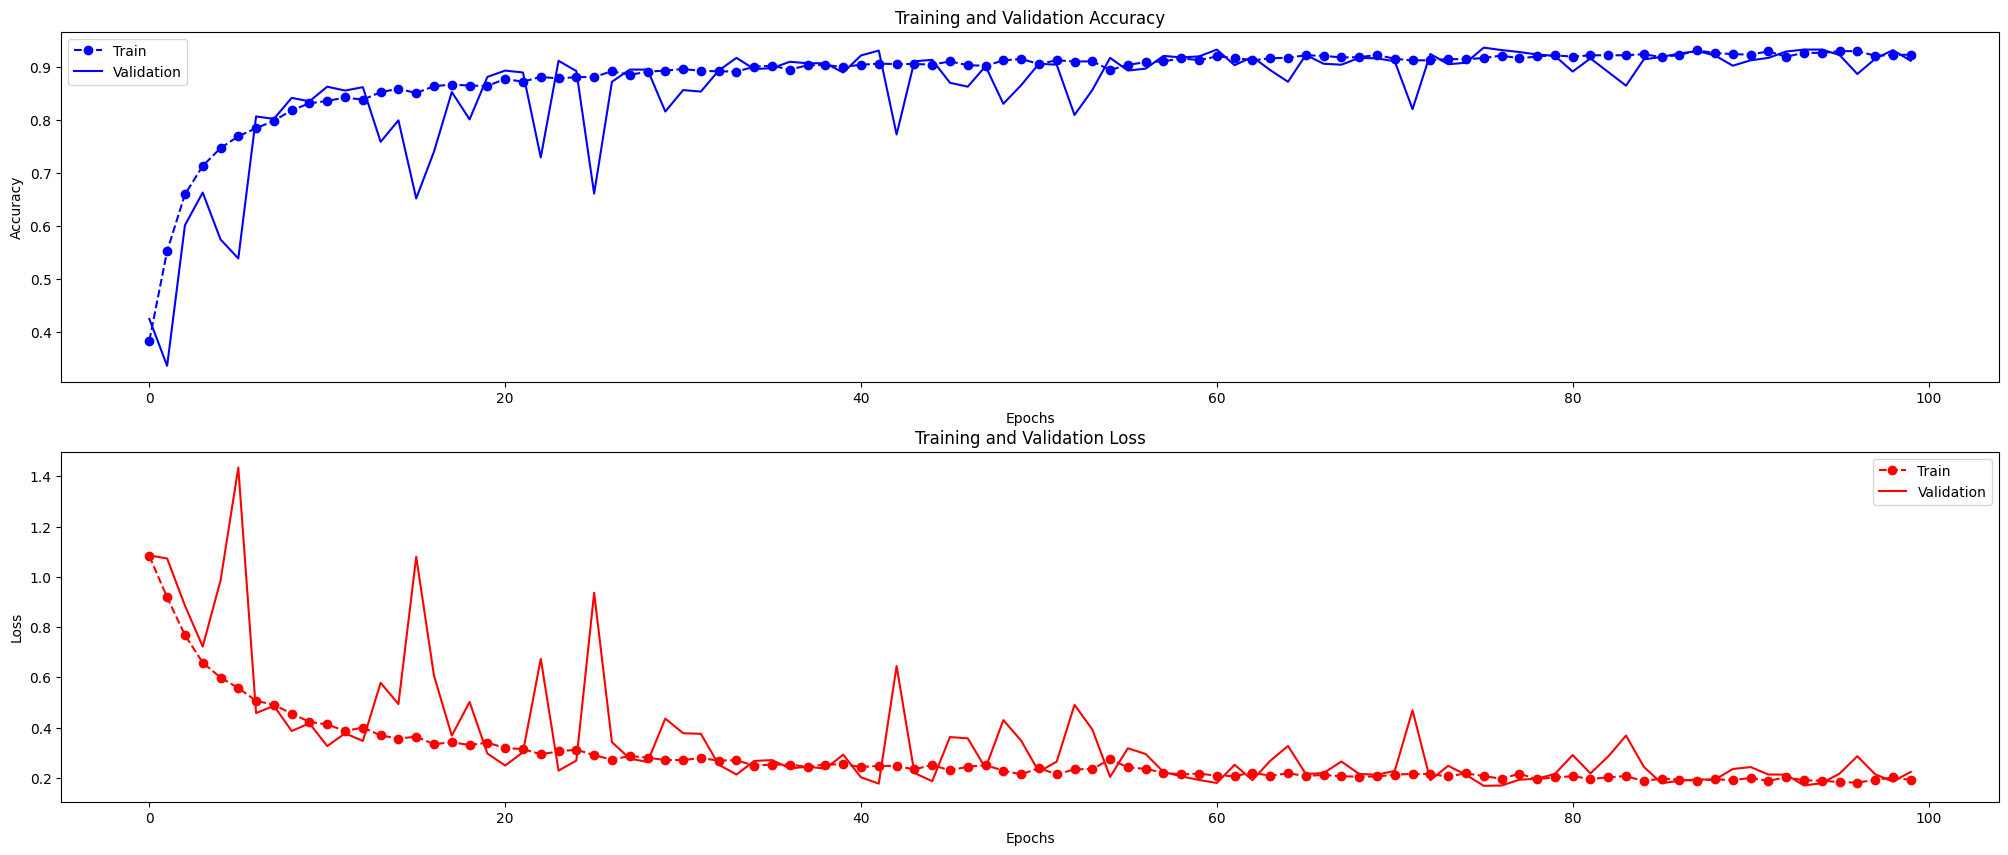

In [22]:
plot_accuracy_and_loss(hist_dict)